In [40]:
import random
import os


import random


def generate_data(nodes_number, x_range, y_range, seed):
    if seed is not None:
        random.seed(seed)

    data = []
    used_coordinates = set()

    while len(data) < nodes_number:
        x = random.randint(x_range[0], x_range[1])
        y = random.randint(y_range[0], y_range[1])

        if (x, y) not in used_coordinates:
            used_coordinates.add((x, y))
            data.append((len(data) + 1, x, y))
    return data


# Function to write the generated data to a file
def write_to_file(filename, data):
    with open(filename, "w") as f:
        for entry in data:
            f.write(f"{entry[0]} {entry[1]} {entry[2]}\n")


NODES_NUMBER = 50
X_RANGE = (0, 50)
Y_RANGE = (0, 50)
SEED = 1
data = generate_data(NODES_NUMBER, X_RANGE, Y_RANGE, SEED)


filename = "TSP.txt"
if os.path.exists(filename):
    os.remove(filename)

write_to_file(filename, data)

print(f"Randomly generated '{NODES_NUMBER}' Cities and written to '{filename}'")

Randomly generated '50' Cities and written to 'TSP.txt'


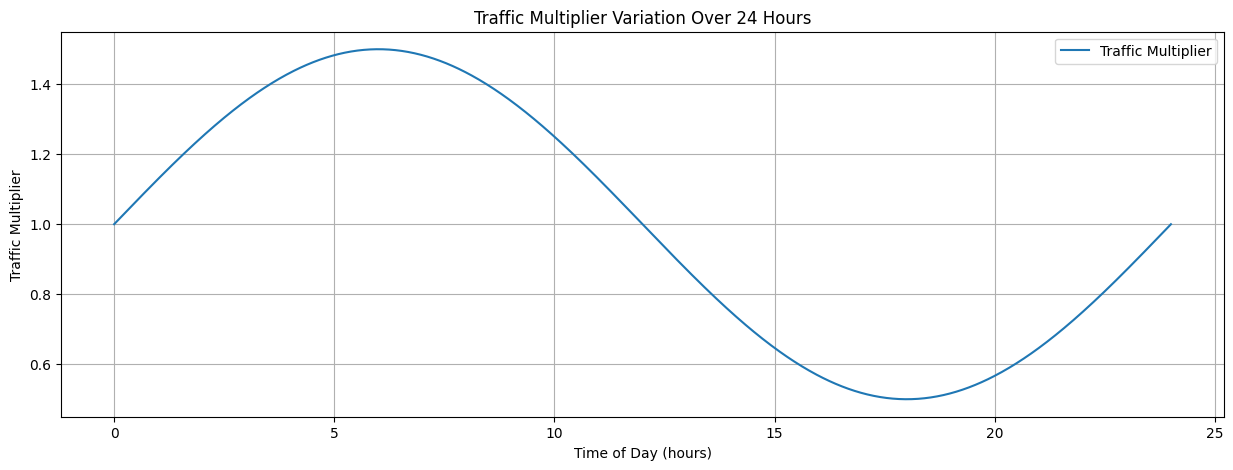

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters for the sine function representing traffic variations
hours = np.linspace(0, 24, 1000)
TRAFFIC_FUNCTION = 1 + 0.5 * np.sin(hours / 24 * 2 * np.pi)

# Plot the sine function
plt.figure(figsize=(15, 5))
plt.plot(hours, TRAFFIC_FUNCTION, label="Traffic Multiplier")
plt.xlabel("Time of Day (hours)")
plt.ylabel("Traffic Multiplier")
plt.title("Traffic Multiplier Variation Over 24 Hours")
plt.grid(True)
plt.legend()
plt.show()

10 777.0856988269561
20 625.4546503461092
30 546.4666490012323
40 482.3663979949577
50 465.1618260802188
60 460.84492630726675
70 454.50743786867116
80 454.3254885298541
90 454.2939416362164
100 454.28757195392694
110 454.28757195392694
120 454.28757195392694
130 454.28757195392694
140 454.28757195392694
150 454.28757195392694
160 454.28757195392694
170 454.28757195392694
180 454.28757195392694
190 454.2873769976724
200 454.2873769976724
210 454.2873769976724
220 454.2873769976724
230 454.2873769976724
240 454.2873769976724
250 454.2873769976724
260 454.2873769976724
270 454.2873769976724
280 454.2873769976724
Early stopping at generation 283 with best score: 454.2873769976724
Answer :  [454.2873769976724, [['18', 41.0, 34.0], ['13', 28.0, 17.0], ['27', 43.0, 14.0], ['10', 27.0, 38.0], ['11', 48.0, 49.0], ['48', 49.0, 43.0], ['24', 28.0, 31.0], ['1', 8.0, 36.0], ['8', 6.0, 31.0], ['23', 14.0, 48.0], ['29', 18.0, 1.0], ['35', 21.0, 46.0], ['21', 27.0, 46.0], ['37', 27.0, 32.0], ['5', 28

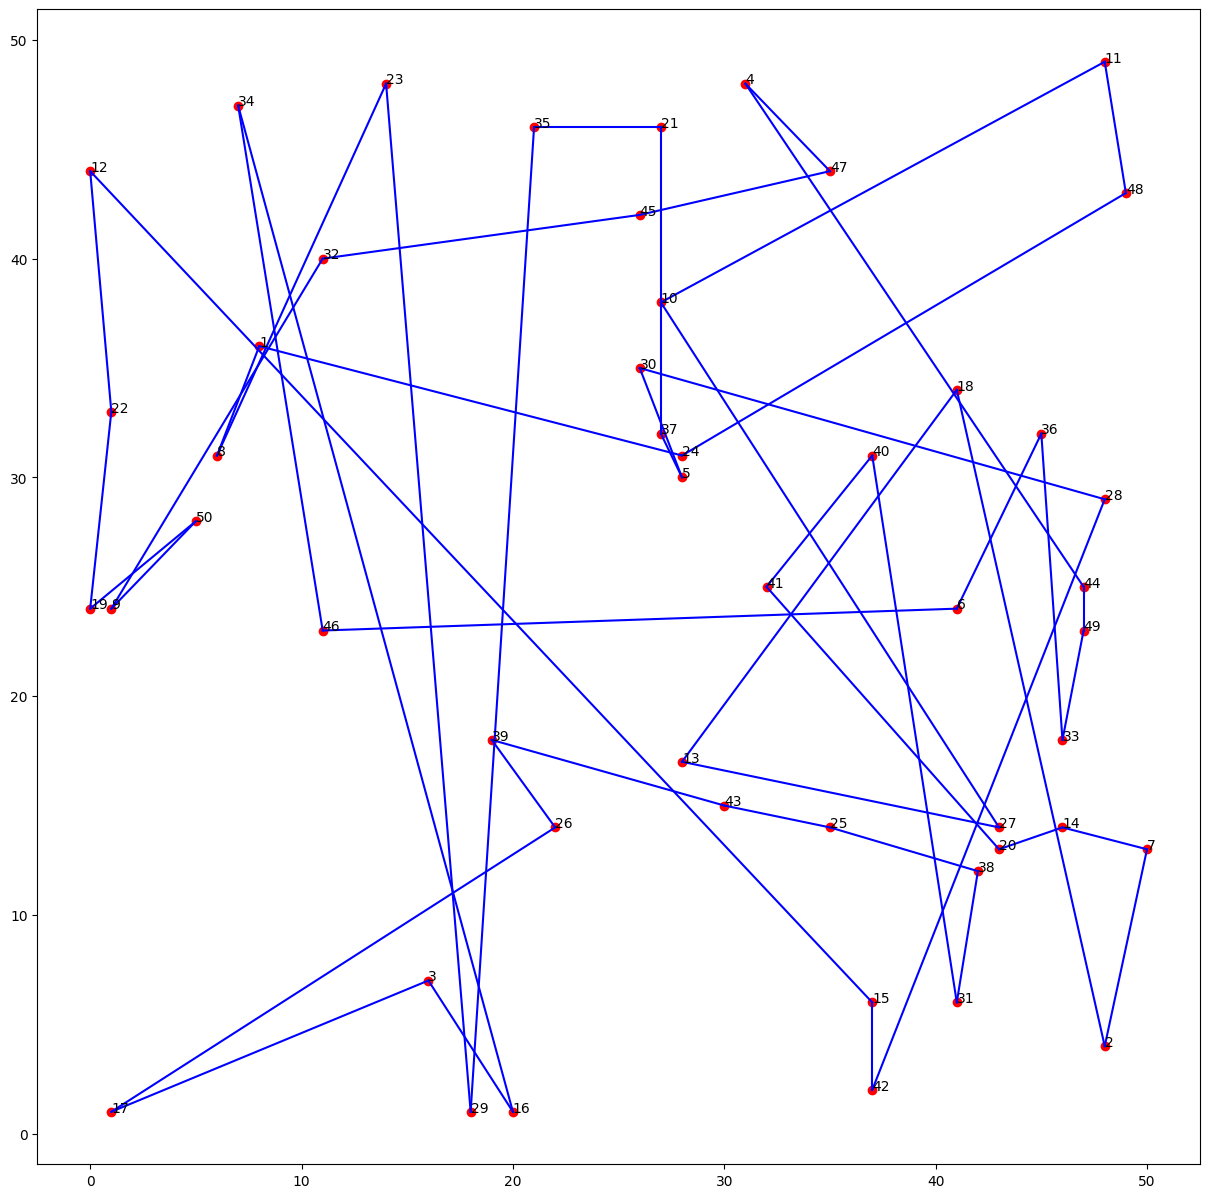

In [42]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np


# Function to get cities information from a file
def get_city():
    cities = []
    # Open the file containing city information
    f = open("TSP.txt")
    for i in f.readlines():
        node_city_val = i.split()
        # Append city information to the list
        cities.append(
            [node_city_val[0], float(node_city_val[1]), float(node_city_val[2])]
        )
    return cities


# Function to calculate the travel time based on traffic variations
def calculate_travel_time(cityA, cityB, time):
    base_distance = math.sqrt(
        math.pow(cityB[1] - cityA[1], 2) + math.pow(cityB[2] - cityA[2], 2)
    )
    # Simulate traffic variation with a sine function
    traffic_multiplier = 1 + 0.5 * np.sin(time / 24 * 2 * np.pi)
    travel_time = base_distance * traffic_multiplier
    # print(f"travel_time between {cityA[0]} & {cityB[0]} : {travel_time}")
    return travel_time


# Function to calculate the total distance of the path
def calculate_total_time(cities):
    total_time = 0
    current_time = 0
    for i in range(len(cities) - 1):
        cityA = cities[i]
        cityB = cities[i + 1]
        # Calculate the travel time between two cities considering the time of day
        travel_time = calculate_travel_time(cityA, cityB, current_time)
        total_time += travel_time
        current_time += travel_time

    # Calculate the time to return to the starting city
    cityA = cities[0]
    cityB = cities[-1]
    travel_time = calculate_travel_time(cityB, cityA, current_time)
    total_time += travel_time
    # print("-----------------------------------")
    # print(f"total_time {total_time}")
    # print("-----------------------------------")
    return total_time


# Function to create the initial population
def select_population(cities, size):
    population = []
    for i in range(size):
        c = cities.copy()
        # Shuffle cities to create a random path
        random.shuffle(c)
        total_time = calculate_total_time(c)
        # Append the path and its total time to the population
        population.append([total_time, c])
    fittest = sorted(population)[0]
    return population, fittest


# Function to perform the genetic algorithm
def genetic_algorithm(
    population,
    lenCities,
    GENERATIONS_NUMBER,
    TOURNAMENT_SELECTION_SIZE,
    MUTATION_RATE,
    CROSSOVER_RATE,
):
    gen_number = 0
    best_score = None
    same_score_count = 0

    for i in range(GENERATIONS_NUMBER):
        new_population = []
        # Selecting the two best options (elitism)
        new_population.append(sorted(population)[0])
        new_population.append(sorted(population)[1])

        for i in range(int((len(population) - 2) / 2)):
            # Perform crossover based on the crossover rate
            random_number = random.random()
            if random_number < CROSSOVER_RATE:
                parent_chromosome1 = sorted(
                    random.choices(population, k=TOURNAMENT_SELECTION_SIZE)
                )[0]
                parent_chromosome2 = sorted(
                    random.choices(population, k=TOURNAMENT_SELECTION_SIZE)
                )[0]
                point = random.randint(0, lenCities - 1)
                # Create child chromosomes by combining parts of parent chromosomes
                child_chromosome1 = parent_chromosome1[1][0:point]
                for j in parent_chromosome2[1]:
                    if j not in child_chromosome1:
                        child_chromosome1.append(j)
                child_chromosome2 = parent_chromosome2[1][0:point]
                for j in parent_chromosome1[1]:
                    if j not in child_chromosome2:
                        child_chromosome2.append(j)
            else:
                child_chromosome1 = random.choices(population)[0][1]
                child_chromosome2 = random.choices(population)[0][1]
            # Perform mutation based on the mutation rate
            if random.random() < MUTATION_RATE:
                point1 = random.randint(0, lenCities - 1)
                point2 = random.randint(0, lenCities - 1)
                child_chromosome1[point1], child_chromosome1[point2] = (
                    child_chromosome1[point2],
                    child_chromosome1[point1],
                )
                point1 = random.randint(0, lenCities - 1)
                point2 = random.randint(0, lenCities - 1)
                child_chromosome2[point1], child_chromosome2[point2] = (
                    child_chromosome2[point2],
                    child_chromosome2[point1],
                )
            # Add new children to the population
            new_population.append(
                [calculate_total_time(child_chromosome1), child_chromosome1]
            )
            new_population.append(
                [calculate_total_time(child_chromosome2), child_chromosome2]
            )
        population = new_population
        gen_number += 1

        # Get the best score of the current generation
        current_best_score = sorted(population)[0][0]

        # Check if the best score has remained the same
        if current_best_score == best_score:
            same_score_count += 1
        else:
            best_score = current_best_score
            same_score_count = 0

        # Stop if the best score has been the same for more than 50 generations
        if same_score_count > 100:
            print(
                f"Early stopping at generation {gen_number} with best score: {best_score}"
            )
            break

        # Print the best distance every 10 generations
        if gen_number % 10 == 0:
            print(gen_number, current_best_score)

    answer = sorted(population)[0]
    print("Answer : ", answer)
    return answer


# Function to draw the cities and the best path found
def drawMap(city, answer):
    plt.figure(figsize=(15, 15))
    for j in city:
        # Plot each city
        plt.plot(j[1], j[2], "ro")
        plt.annotate(j[0], (j[1], j[2]))
    for i in range(len(answer[1])):
        try:
            first = answer[1][i]
            second = answer[1][i + 1]
            # Draw the path between cities
            plt.plot([first[1], second[1]], [first[2], second[2]], "blue")
        except:
            continue
    # Draw the path back to the start to complete the loop
    first = answer[1][0]
    second = answer[1][-1]
    plt.plot([first[1], second[1]], [first[2], second[2]], "blue")
    plt.show()


def main():
    GENERATIONS_NUMBER = 400
    POPULATION_SIZE = 3000
    TOURNAMENT_SELECTION_SIZE = 5
    MUTATION_RATE = 0.1
    CROSSOVER_RATE = 0.8
    cities = get_city()
    # Select the initial population and the fittest individual
    firstPopulation, firstFittest = select_population(cities, POPULATION_SIZE)
    answer = genetic_algorithm(
        firstPopulation,
        len(cities),
        GENERATIONS_NUMBER,
        TOURNAMENT_SELECTION_SIZE,
        MUTATION_RATE,
        CROSSOVER_RATE,
    )
    print("\n----------------------------------------------------------------")
    print(f"Initial generation result : {str(firstFittest[0])}")
    print(f"Best generation result : {str(answer[0])}")
    print("----------------------------------------------------------------\n")
    drawMap(cities, answer)


main()